SIFT - Scale-Invariant Feature Transform
====================

For this notebook, that will likely take a while, I am going to go through and implement the SIFT algorithm
from scratch.  I am working on SIFT as it is one of the best object detection algorithms that doesn't
require a convolutional neural network to be trained.  We are going to use this to extract useful features to use
in a clustering operation. 

To give you an idea of what we are trying to create in the end I am going to display the output that comes
from opencv's implementation of SIFT.  

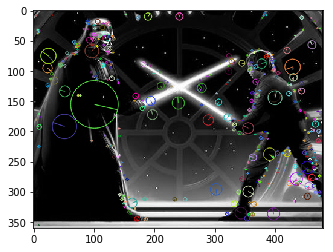

In [2]:
import os
import cv2

import matplotlib.pyplot as plt

IMAGE_PATH = os.path.join(os.getcwd(), '..', 'raw_data', 'star_wars', 'star-wars-saber.jpg')

img = cv2.imread(IMAGE_PATH)
plt.imshow(img)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#gray = bw_image

# Create a SIFT Object
sift = cv2.xfeatures2d.SIFT_create()
 
# Get the Key Points from the 'gray' image, this returns a numpy array
kp = sift.detect(gray, None)
 
# Now we drawn the gray image and overlay the Key Points (kp)
img = cv2.drawKeypoints(gray, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
# Plot it to the screen, looks a little small
plt.imshow(img)

Alright now that we have our goal in mind, lets start by importing some common libraries. 

In [2]:
# Common Libraries to load
import os

import numpy as np

from PIL import Image
from dataclasses import dataclass
from typing import List

As we go through this algorithm we are going to go step by step into the details and see how each operation is effecting
the image.  For this to occur we need to have a good example image we want to use.  

The image that I decided to go with was a random image found from google based on star wars.  
[Star Wars Saber Duel](https://i.ytimg.com/vi/6CRWj_teWqI/hqdefault.jpg)

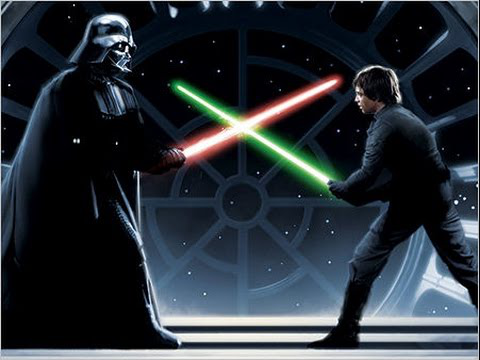

In [3]:
IMAGE_PATH = os.path.join(os.getcwd(), '..', 'raw_data', 'star_wars', 'star-wars-saber.jpg')
#IMAGE_PATH = os.path.join(os.getcwd(), '..', 'raw_data', 'gaussian', 'gaussian_blur_example.png')
original_img = Image.open(IMAGE_PATH)
display(original_img)

## Basic Operations

To even begin to work with SIFT we need to have in place a way to do image convolutions as well as a gaussian function
to work on image smoothing.  Lets start with both of these functions. 

The first thing we are going to create are some helper classes that we can use to more easily manage and pass around the
data.  We are going to use python `dataclasses` for these objects (current using a package as native support is only for 3.7 and above). 


In [4]:
@dataclass
class ImageData:
    image_data: List[int]
    width: int
    height: int
            
    @property
    def data(self):
        return self.image_data
    
    def copy(self):
        return ImageData(list(self.data), width, height)

@dataclass
class Kernel:
    kernel_values: List[int]
    radius: int
        
    @property
    def kernel(self):
        return self.kernel_values
    
    @property
    def size(self):
        return (self.radius * 2) + 1
    
    def __repr__(self):
        result = ''
        for row in range(self.size):
            row_str = ' '.join([format(self.kernel[row * self.size + c], '0.6f') for c in range(self.size)])
            result += row_str + '\n'
        return result

The next thing we need to create is our function for convolving an image given a kernel.  In this case we are going
to define two different functions.  

- `kernel_op` will be the function that takes a pixel location and a kernel and calculates the new value. 
- `convolv_image` will be the function that takes an image, a kernel and returns the resulting image.

There is one very important feature we need to add to our `kernel_op`.  If the pixel requested is located in an area
that the full kernel cannot be applied, a sub kernel will be created from the specified region and normalized before
being used. 

In [5]:
def kernel_op(image: ImageData, kernel: Kernel, x: int, y: int, color_index: int = None, **kwargs):
    """
    Function to take in image_data, kernel and x,y of image and calculates the average
    value based on the real data and supplied kernel. 
    """
    def calc_pixel(x_off, y_off):
        x_img = x + x_off
        y_img = y + y_off
        if x_img < 0 or x_img >= image.width:
            return 0, 0
        if y_img < 0 or y_img >= image.height:
            return 0, 0
        
        img_offset = (y_img * image.width) + x_img
        kernel_offset = ((y_off + kernel.radius) * kernel.size) + (x_off + kernel.radius)
        op_value = kernel.kernel[kernel_offset]
        image_value = image.data[img_offset]
        if color_index is not None:
            image_value = image_value[color_index]
            
        #print(y_off, x_off, img_offset, kernel_offset, op_value, image_value, image_value * op_value)
        return (image_value * op_value, op_value)

    converted = 0
    div_sum = 0
    for y_diff in range(kernel.radius*2 + 1):
        for x_diff in range(kernel.radius*2 + 1):
            new_value, new_div = calc_pixel(-kernel.radius + x_diff, -kernel.radius + y_diff)
            #print(new_value, new_div)
            converted += new_value
            div_sum += new_div
            
    return int(converted / div_sum)

def test_kernel_op():
    kernel = Kernel([ 0, 0.5, 0, 
                     0.5, 1, 0.5,
                      0, 0.5, 0], radius=1)
    
    image = ImageData([10, 11, 100, 20, 50,
                       10, 43, 100, 25, 55,
                       25, 40, 50, 24, 55,
                       33, 40, 25, 12, 10,
                       10, 11, 100, 20, 50], width=5, height=5)
    
    x, y = 2, 2
    #expected = int((100 * 0.5) + (40 * 0.5) + 50 + (24 * 0.5) + (25 * 0.5)) / 3
    expected = 48    # ((100 * 0.5) + (40 * 0.5) + 50 + (24 * 0.5) + (25 * 0.5)) / 3
    actual = kernel_op(image, kernel, x, y)
    assert actual == expected

test_kernel_op()

In [6]:
def convolv_image(raw_image, kernel):
    image = ImageData(list(raw_image.getdata()), raw_image.width, raw_image.height)
    
    tuple_type = type(image.data[0]) == tuple
    cell_length = None if not tuple_type else len(image.data[0])
    
    updated_data = []
    for y in range(image.height):
        for x in range(image.width):
            if cell_length:
                updated_points = []
                for i in range(cell_length):
                    updated_points.append(kernel_op(image, kernel, x, y, color_index=i))
                updated_value = tuple(updated_points)
            else:
                updated_value = kernel_op(image, kernel, x, y)
            updated_data.append(updated_value)

    return_image = raw_image.copy()
    return_image.putdata(updated_data)
    return return_image

We now have our helper functions, but we are missing the kernel to use.  To start we are going to use a simple
weighted kernel that uses pixels that are either directly above or to the side of the current pixel as well as 
making the value of the pixel twice as important.  

In [7]:
simple_kernel = Kernel(radius=1, kernel_values=[0, 1, 0,
                                                1, 2, 1,
                                                0, 1, 0])

display(simple_kernel)

0.000000 1.000000 0.000000
1.000000 2.000000 1.000000
0.000000 1.000000 0.000000

Lets apply our kernel to our original image and compare the difference.    

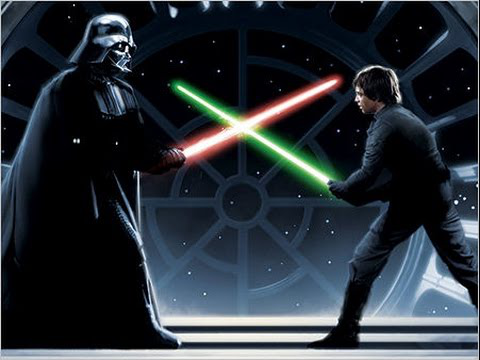

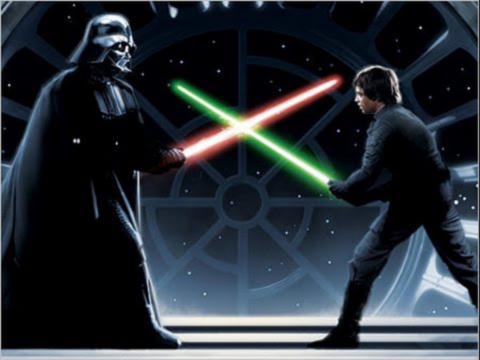

In [8]:
display(original_img)
display(convolv_image(original_img, simple_kernel))

So the simple kernel does a nice job of just lightly blending the different edges.  But what we really want
is a kernel that is based on a gaussian function (function of a normal distribution).  

So lets now introduce a new `kernel` that works be returning the value from a two dimensional gaussian function
defined below.

$$G(x, y, \sigma) = \frac{1}{2 \pi \sigma^2}e^{\frac{-(x^2 + y^2)} {2 \sigma^2}}$$

In [9]:
def gaussian_kernel(std=0.84089642, radius=1, normalize=True):
#     if radius is None:
#         radius = int(abs(std))
#         if radius <= 0:
#             radius = 1

    sigma_squared = np.power(std, 2) * 2
    sigma_squared_pi = 1 / (sigma_squared * np.pi)
    
    def calculate_gaussian(x, y):
        upper = ((np.power(x, 2) + np.power(y, 2)) * -1) / sigma_squared
        return sigma_squared_pi * np.exp(upper)
        
    kernel = []
    kernel_size = (radius * 2) + 1
    for y in range(kernel_size):
        for x in range(kernel_size):
            kernel.append(calculate_gaussian(-radius + x, -radius + y))
            
    if normalize:
        total = sum(kernel)
        kernel = [k/total for k in kernel]
    
    return Kernel(kernel, radius)

def test_gaussian_kernel():
    expected_kernel = [0.00078634, 0.00655965, 0.01330373, 0.00655965, 0.00078633,
                       0.00655965, 0.05472157, 0.11098164, 0.05472157, 0.00655965,
                       0.01330373, 0.11098164, 0.22508352, 0.11098164, 0.01330373,
                       0.00655965, 0.05472157, 0.11098164, 0.05472157, 0.00655965,
                       0.00078633, 0.00655965, 0.01330373, 0.00655965, 0.00078633]
    kernel = gaussian_kernel(std=0.84089642, radius=2, normalize=False)
    actual_kernel = kernel.kernel
    
    for a, e in zip(actual_kernel, expected_kernel):
        assert abs(a - e) < 0.00001

test_gaussian_kernel()

So we have a program that generates a kernel for us based on a gaussian function.  

**NOTE:** I had to spend a bit of time getting this to work.  It turns out that (for whatever reason) to actually
see the larger deviation blur effects you need to increase the radius of the kernel (how far from a center point it 
should be).  This does seem to make sense according to the documentation found on wikipedia that described
the radius as being distance from std.  However it is important to call out that currently __THE LARGER THE RADIUS
THE LONGER IT TAKES TO RUN... LIKE A LOT__

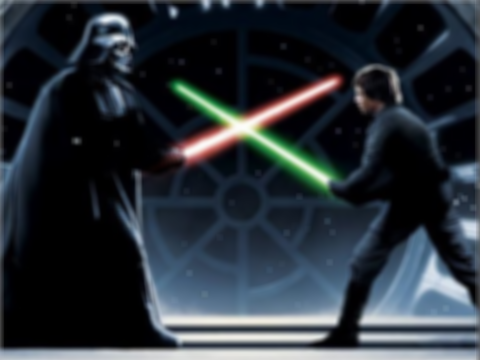

In [10]:
## Stdev = 3
display(convolv_image(original_img, kernel=gaussian_kernel(std=3, radius=3)))

In [11]:
## Stdev = 10
### This takes a while, so not running right now. 
#display(convolv_image(original_img, kernel=gaussian_kernel(std=10, radius=10)))

## Different Scales and Blurs

Sift need to take difference between gaussian blurred images and uses those differences to start generating different
keypoints.  To get the most information we will want to make sure that we get different `blur-levels` and `octaves` from an
image.  These operations are defined below.  

- `octave` Is the size of the image, usually adjusted by half of the previous octave (* except for the first)
- `blur-levels` The number of different gaussian functions to use on a given octave.  

Now there is no required number of octaves or blur-levels, however it is recommended to use 4 octaves and 5 blur-levels
with the first octave actually being based on an image that is twice the size of the original.  

**NOTE:** To try to make execution faster I am going to have the next examples based on a grayscale version of the
image instead of the full spectrum. 

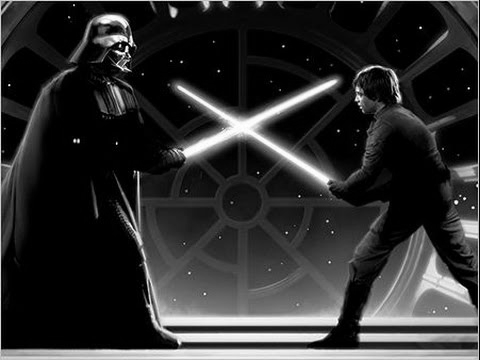

In [12]:
bw_image = original_img.convert('L')
display(bw_image)

Lets now create the `octave_creator` function that will take in an image and return a list of octaves, containing all the
different blurs (in order of blur level)

In [13]:
def octave_creator(image, octaves=4, blur_levels=5, k=np.sqrt(2), std=0.707107):
    current_image = image.resize((image.size[0]*2, image.size[1]*2), Image.ANTIALIAS)
    
    
    stored_images = []
    scale_std = std
    for i in range(octaves):
        print(f'Processing octave: {i+1}')
        octave_images = [] #current_image]
        last_image = current_image
        kernel_std = scale_std
        for b in range(1, blur_levels+1):
            kernel = gaussian_kernel(std=kernel_std)
            print(f'Processing blur level: {b} - {kernel_std}')
            last_image = convolv_image(last_image, kernel=kernel)
            octave_images.append(last_image)
            kernel_std *= k
        stored_images.append(octave_images)
        
        if (i+1) < octaves:
            current_image = current_image.resize([int(i/2) for i in current_image.size])
            
        scale_std += scale_std
            
    return stored_images

In [14]:
sample_octaves = octave_creator(bw_image)

Processing octave: 1
Processing blur level: 1 - 0.707107
Processing blur level: 2 - 1.0000003094489522
Processing blur level: 3 - 1.4142140000000003
Processing blur level: 4 - 2.000000618897905
Processing blur level: 5 - 2.828428000000001
Processing octave: 2
Processing blur level: 1 - 1.414214
Processing blur level: 2 - 2.0000006188979045
Processing blur level: 3 - 2.8284280000000006
Processing blur level: 4 - 4.00000123779581
Processing blur level: 5 - 5.656856000000002
Processing octave: 3
Processing blur level: 1 - 2.828428
Processing blur level: 2 - 4.000001237795809
Processing blur level: 3 - 5.656856000000001
Processing blur level: 4 - 8.00000247559162
Processing blur level: 5 - 11.313712000000004
Processing octave: 4
Processing blur level: 1 - 5.656856
Processing blur level: 2 - 8.000002475591618
Processing blur level: 3 - 11.313712000000002
Processing blur level: 4 - 16.00000495118324
Processing blur level: 5 - 22.62742400000001


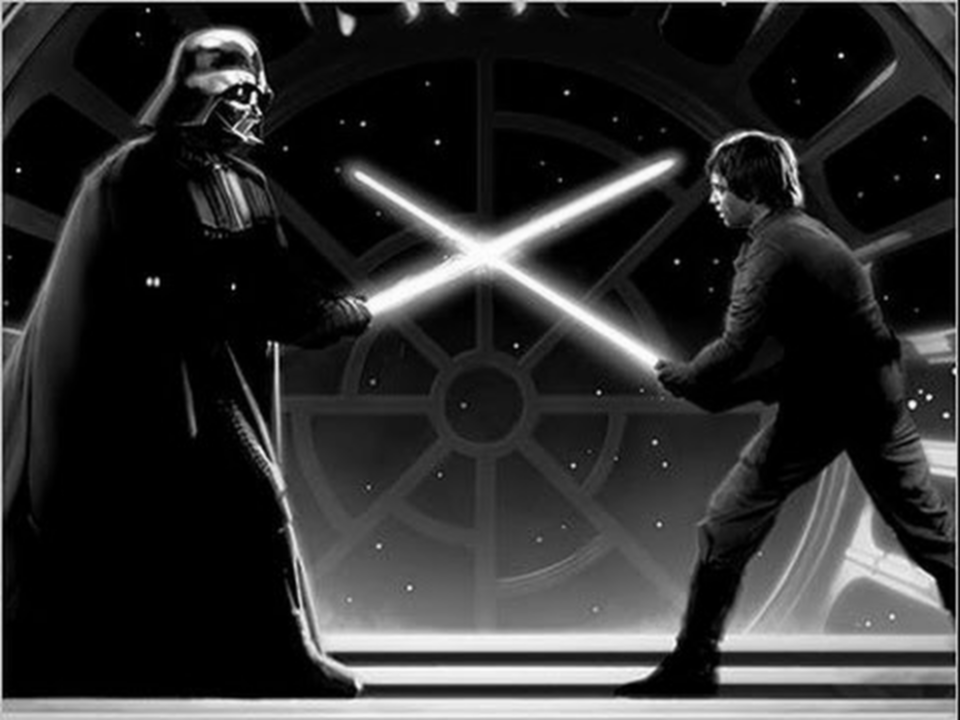

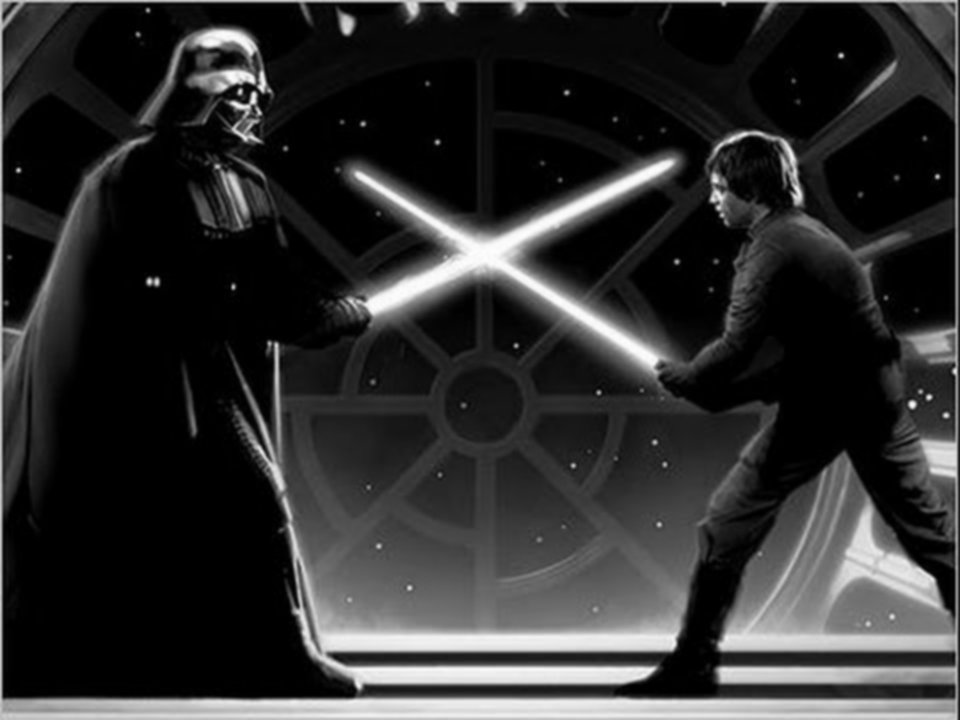

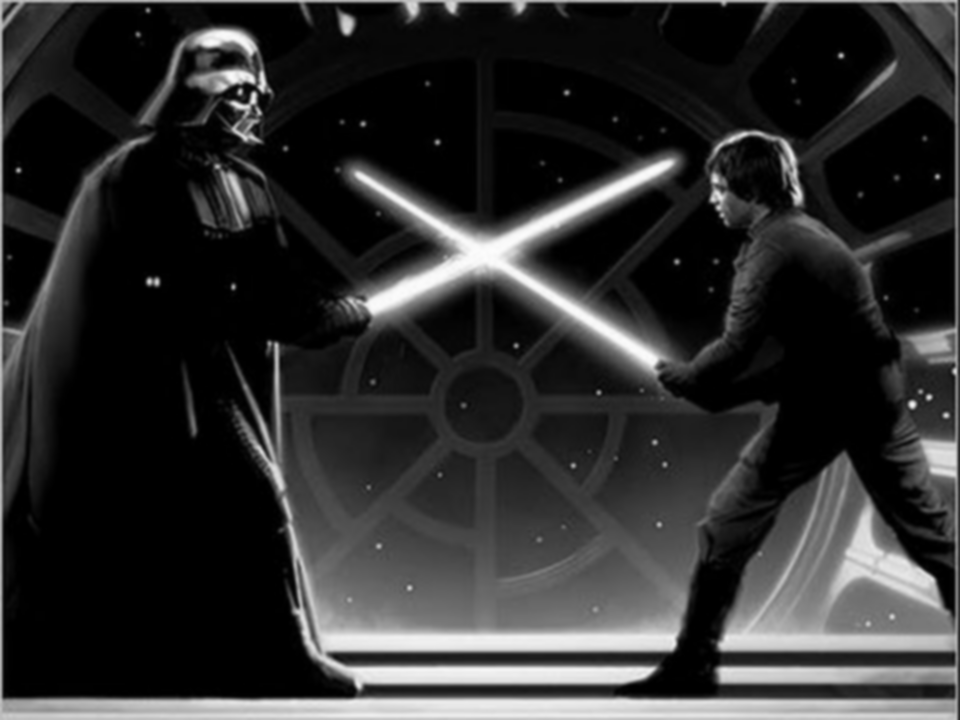

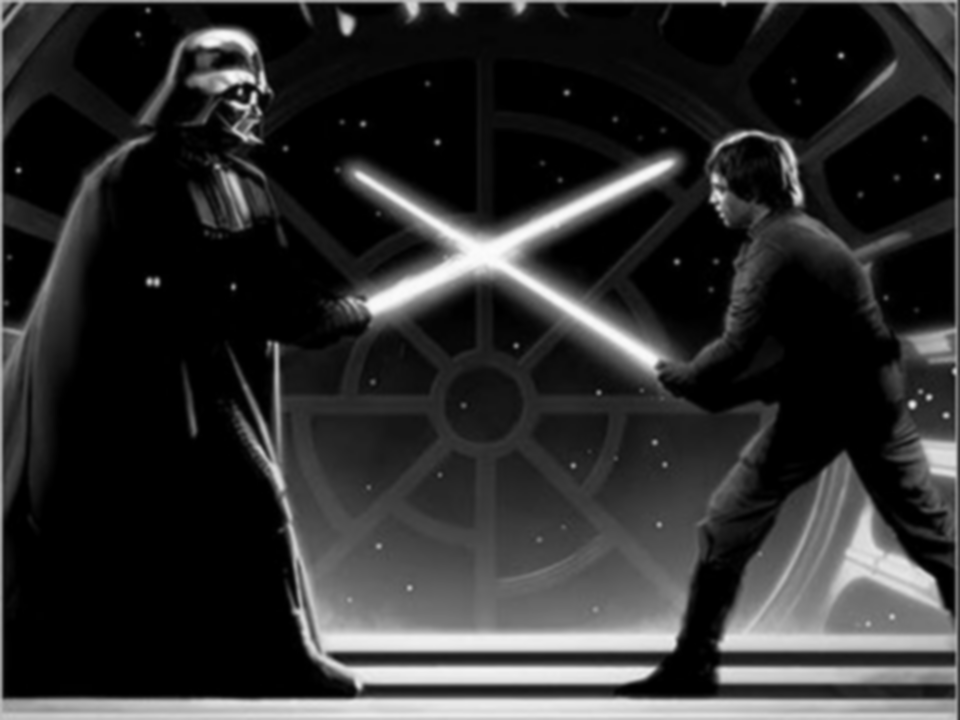

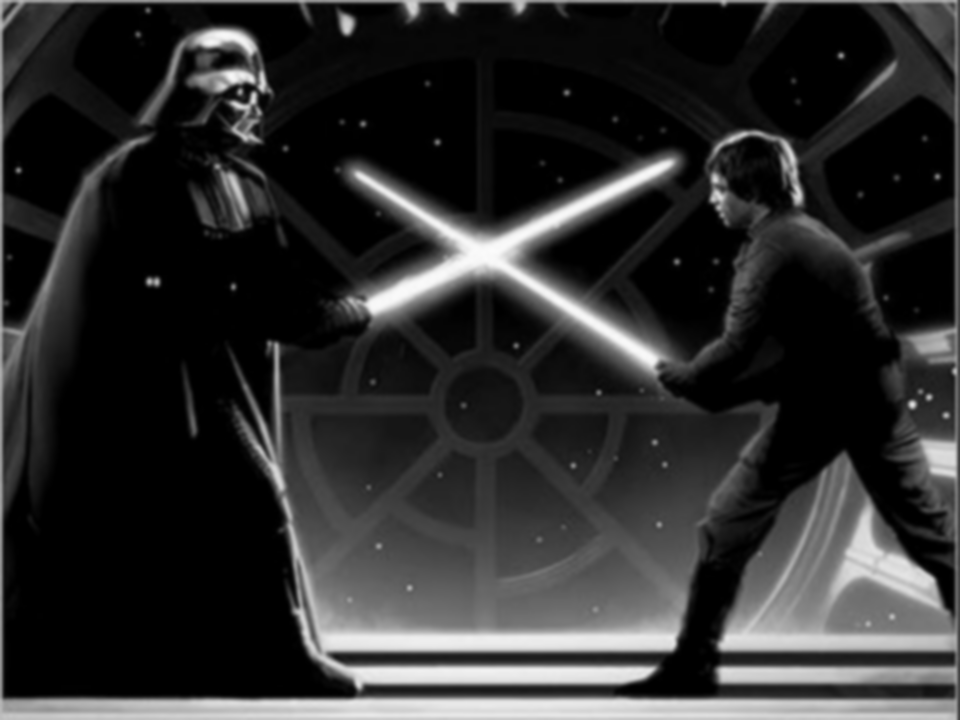

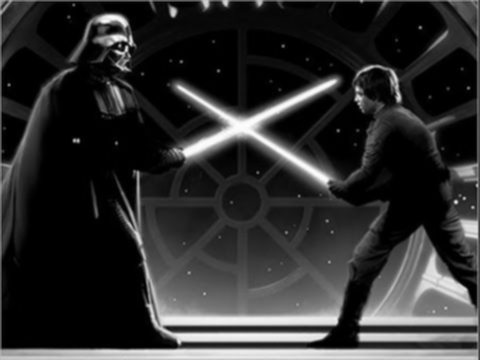

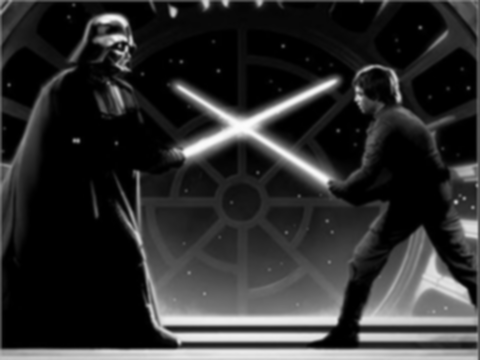

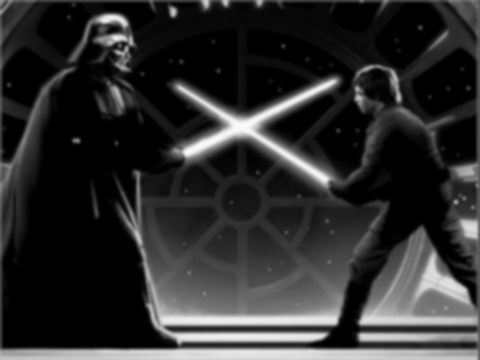

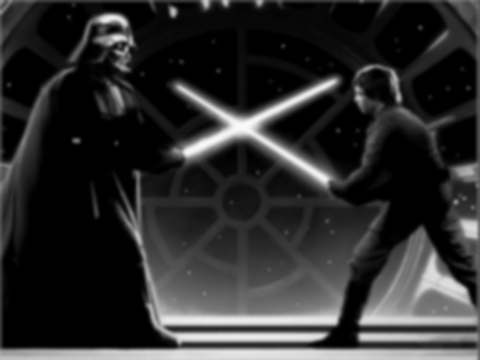

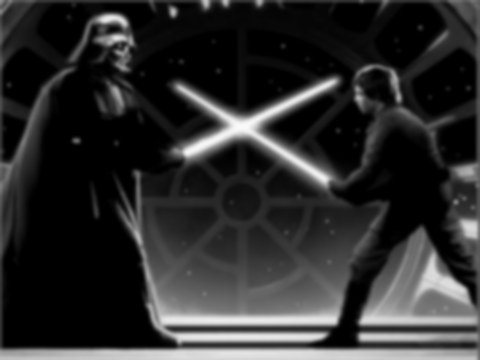

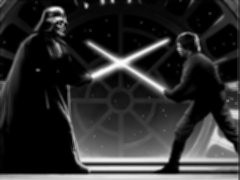

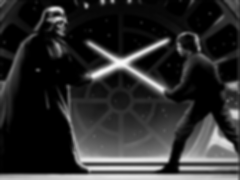

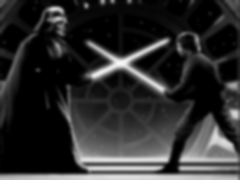

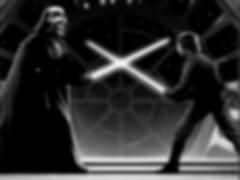

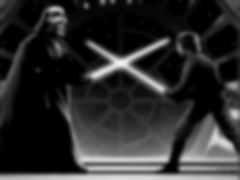

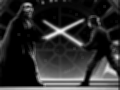

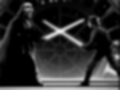

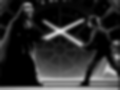

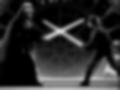

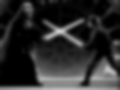

In [15]:
for level in sample_octaves:
    for img in level:
        display(img)

So now we have a solution for the generation, however it is written in python and is going to be slow, lets now create
the same method using opencv's library methods (like filter2D).  

In [16]:
import cv2
import numpy as np

def octave_creator(image, octaves=4, blur_levels=5, *, k=np.sqrt(2), std=0.707107, debug=False, 
                   include_orig=False, up_samples=1): 
    if up_samples is not None:
        for _ in range(up_samples):
            image = image.resize((image.size[0]*2, image.size[1]*2), Image.ANTIALIAS)
    current_image = np.array(image) # cv2.cvtColor(np.array(upsampled_image), cv2.COLOR_RGB2BGR)
    
    stored_images = []
    scale_std = std
    for i in range(octaves):
        if debug:
            print(f'Processing octave: {i+1}')
        
        if include_orig:
            octave_images = [current_image]
        else:
            octave_images = []
            
        last_image = current_image
        kernel_std = scale_std
        for b in range(1, blur_levels+1):
            if debug:
                print(f'Processing blur level: {b} - {kernel_std}')
            last_image = cv2.GaussianBlur(last_image,(5,5),kernel_std)
            octave_images.append(last_image)
            kernel_std *= k
        stored_images.append(octave_images)
        
        if (i+1) < octaves:
            current_image = cv2.resize(current_image, (0,0), fx=0.5, fy=0.5)
            
        scale_std += scale_std
            
    return stored_images

In [17]:
sample_octaves = octave_creator(bw_image, up_samples=None)

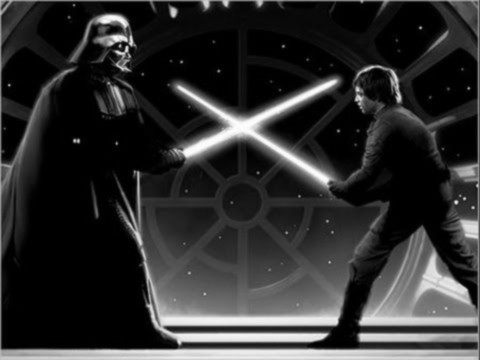

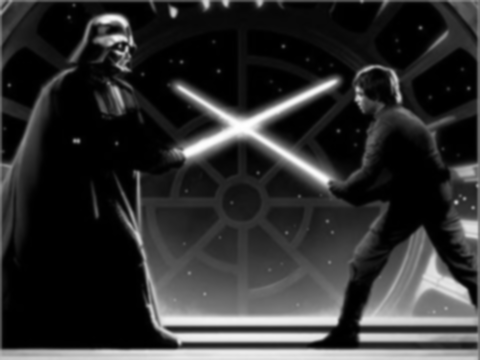

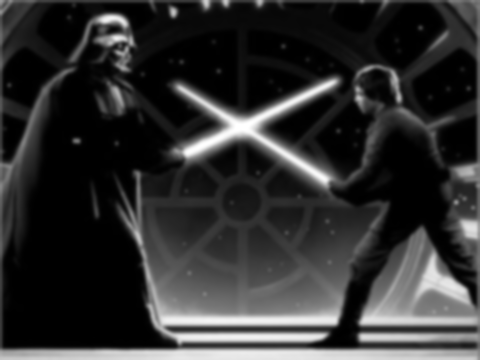

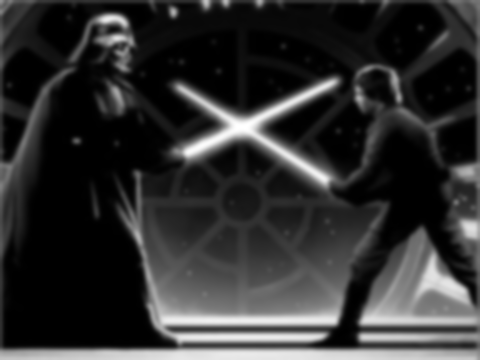

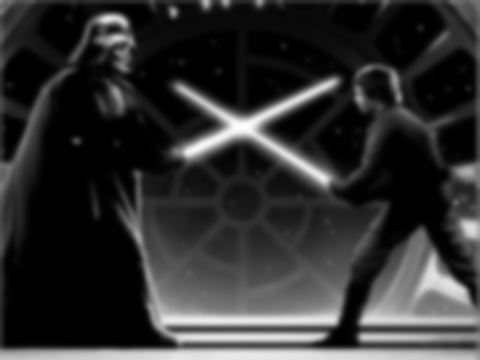

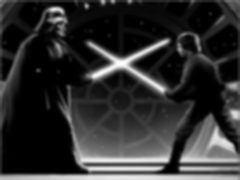

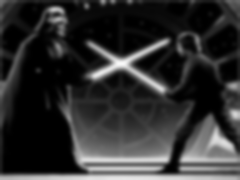

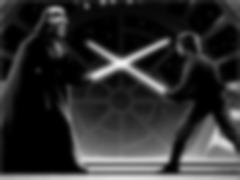

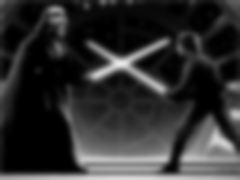

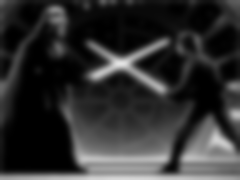

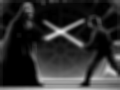

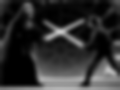

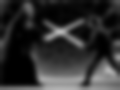

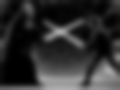

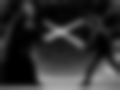

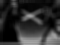

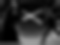

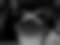

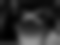

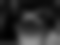

In [18]:
#display(dir(cv2))
for octave in sample_octaves:
    for cv_image in octave:
        #display(Image.fromarray(cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)))
        display(Image.fromarray(cv_image))
    #print(len(cv_image))
    #display(cv2.cvtColor(np.array(cv_image))) #, cv2. cv2.COLOR_BGR2RGB) )

So we now have a function that runs quickly using open_cv to generate a list of octaves and blur_levels that we can use
in our next steps...  the gaussian difference.  

## Todos

According to the wikipedia article on gaussian functions: 

> A Gaussian blur effect is typically generated by convolving an image with a kernel of Gaussian values. In practice, it is best to take advantage of the Gaussian blur’s separable property by dividing the process into two passes. In the first pass, a one-dimensional kernel is used to blur the image in only the horizontal or vertical direction. In the second pass, the same one-dimensional kernel is used to blur in the remaining direction. The resulting effect is the same as convolving with a two-dimensional kernel in a single pass, but requires fewer calculations.

## References

* [AI Shack - SIFT](http://aishack.in/tutorials/sift-scale-invariant-feature-transform-scale-space/)
* [Gaussian Blur - Wikipedia](https://en.wikipedia.org/wiki/Gaussian_blur)
* [Image Convolution Slides - Portland State](http://web.pdx.edu/~jduh/courses/Archive/geog481w07/Students/Ludwig_ImageConvolution.pdf)
